In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("../Data/Hotels_Best_Discount.csv")
X = df[["Snapshot Date", "Checkin Date", "DayDiff", "WeekDay", "Hotel_Encoded_Name"]]
y = df["Discount Code"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [ ]:
#Controls the amount of variance added to the data to prevent division by zero in probability calculations
param_grid = {"var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]}

grid_search = GridSearchCV(GaussianNB(), param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_nb = grid_search.best_estimator_

print("Best Hyperparameters for GaussianNB:", grid_search.best_params_)
y_pred = best_nb.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Training Accuracy: {accuracy:.4f}")
y_pred = best_nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Best Hyperparameters for GaussianNB: {'var_smoothing': 0.0001}
Training Accuracy: 0.3454
Test Accuracy: 0.3471


In [20]:
best_nb = GaussianNB(var_smoothing=0.0001)
best_nb.fit(X_train, y_train)

y_pred = best_nb.predict(X_test)
y_pred_proba = best_nb.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
fp = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
fn = conf_matrix.sum(axis=1) - np.diag(conf_matrix)  

with np.errstate(divide="ignore", invalid="ignore"): 
    precision = np.diag(conf_matrix) / (np.diag(conf_matrix) + fp)
    recall = np.diag(conf_matrix) / (np.diag(conf_matrix) + fn)
precision = np.nan_to_num(precision, nan=0.0)
recall = np.nan_to_num(recall, nan=0.0)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")

print(f"Naïve Bayes Test Accuracy: {accuracy:.4f}")
print(f"Naïve Bayes ROC AUC Score: {roc_auc:.4f}")
print("\nFalse Positives (FP) per class:")
print(fp)
print("\nFalse Negatives (FN) per class:")
print(fn)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Naïve Bayes Test Accuracy: 0.3471
Naïve Bayes ROC AUC Score: 0.5653

False Positives (FP) per class:
[  883 10824  2305     0]

False Negatives (FN) per class:
[5116 1428 4220 3248]

Classification Report:
              precision    recall  f1-score   support

           1       0.36      0.09      0.14      5609
           2       0.33      0.79      0.47      6830
           3       0.40      0.27      0.32      5773
           4       0.00      0.00      0.00      3248

    accuracy                           0.35     21460
   macro avg       0.27      0.29      0.23     21460
weighted avg       0.31      0.35      0.27     21460



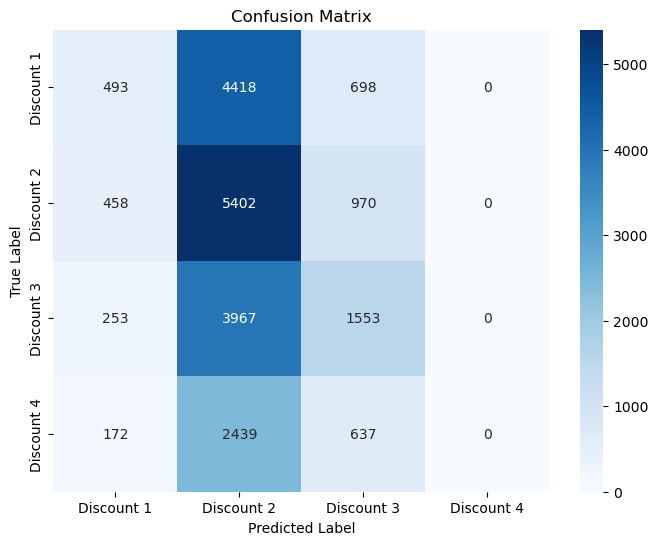

In [21]:
classes = [f"Discount {i}" for i in range(1, len(conf_matrix) + 1)]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

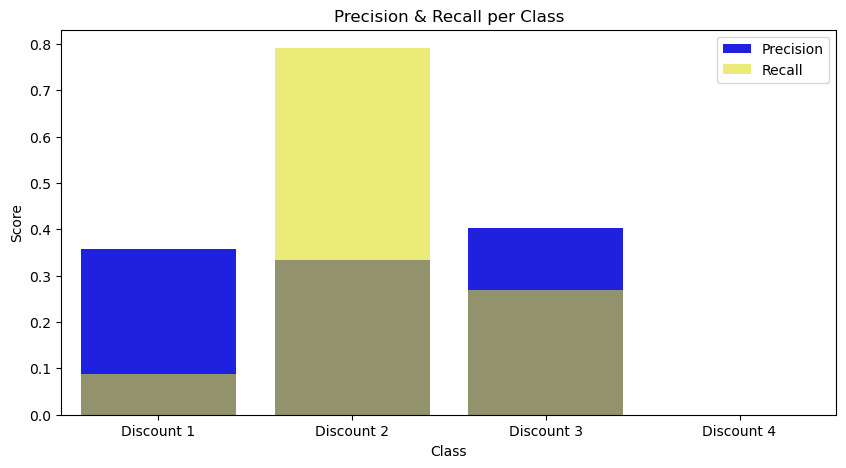

In [22]:
df_metrics = pd.DataFrame({"Class": classes, "Precision": precision, "Recall": recall})

plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Precision", data=df_metrics, color="blue", label="Precision")
sns.barplot(x="Class", y="Recall", data=df_metrics, color="yellow", alpha=0.6, label="Recall")
plt.ylabel("Score")
plt.title("Precision & Recall per Class")
plt.legend()
plt.show()

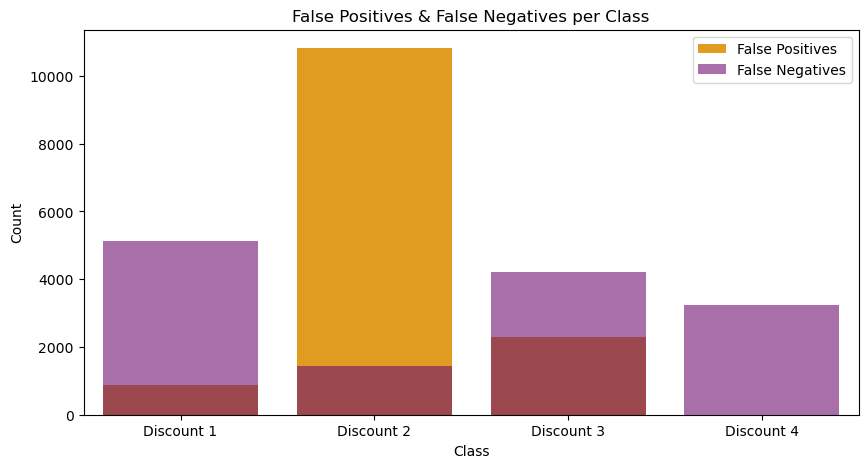

In [23]:
df_fp_fn = pd.DataFrame({"Class": classes, "False Positives": fp, "False Negatives": fn})

plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="False Positives", data=df_fp_fn, color="orange", label="False Positives")
sns.barplot(x="Class", y="False Negatives", data=df_fp_fn, color="purple", alpha=0.6, label="False Negatives")
plt.ylabel("Count")
plt.title("False Positives & False Negatives per Class")
plt.legend()
plt.show()

### **Conclusion: Naïve Bayes Performance**
Naïve Bayes performed poorly on our dataset.  

- **Accuracy (34.7%)** was significantly lower than other algorithms.  
- **ROC AUC Score (0.5653)** suggests the model is barely better than random guessing.  
- **Severe class imbalance** – Since class 2 is the most represented, Naïve Bayes assigns it the highest prior probability, leading to many false positives (10,824 FP!).  
  Conversely, class 4 is the least represented, so the model assigns it a near-zero probability, resulting in no predictions for class 4 at all.  
- **Feature independence assumption failed** – Naïve Bayes assumes that all features are independent, but in our dataset, this is not the case.  
  We know even without checking that most features are related. For example, `(Check-in Date - 1) % 7 = Weekday`, showing a direct dependency.  

